# **Project 4**

In [6]:
from glob import glob
import os
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [7]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [8]:
!unzip ufc10.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ufc10/frames/train/WallPushups/v_WallPushups_g05_c01/frame_1.jpg  
  inflating: ufc10/frames/train/WallPushups/v_WallPushups_g05_c01/frame_10.jpg  
  inflating: ufc10/frames/train/WallPushups/v_WallPushups_g05_c01/frame_5.jpg  
  inflating: ufc10/frames/train/WallPushups/v_WallPushups_g05_c01/frame_7.jpg  
   creating: ufc10/frames/train/WallPushups/v_WallPushups_g04_c01/
  inflating: ufc10/frames/train/WallPushups/v_WallPushups_g04_c01/frame_4.jpg  
  inflating: ufc10/frames/train/WallPushups/v_WallPushups_g04_c01/frame_2.jpg  
  inflating: ufc10/frames/train/WallPushups/v_WallPushups_g04_c01/frame_3.jpg  
  inflating: ufc10/frames/train/WallPushups/v_WallPushups_g04_c01/frame_6.jpg  
  inflating: ufc10/frames/train/WallPushups/v_WallPushups_g04_c01/frame_9.jpg  
  inflating: ufc10/frames/train/WallPushups/v_WallPushups_g04_c01/frame_8.jpg  
  inflating: ufc10/frames/train/WallPushups/v_WallPush

## Dataloader

In [9]:
class FrameImageDataset(torch.utils.data.Dataset):
    def __init__(self,
    root_dir='ufc10',
    split='train',
    transform=None
):
        self.frame_paths = sorted(glob(f'{root_dir}/frames/{split}/*/*/*.jpg'))
        self.df = pd.read_csv(f'{root_dir}/metadata/{split}.csv')
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.frame_paths)

    def _get_meta(self, attr, value):
        return self.df.loc[self.df[attr] == value]

    def __getitem__(self, idx):
        frame_path = self.frame_paths[idx]
        video_name = frame_path.split('/')[-2]
        video_meta = self._get_meta('video_name', video_name)
        label = video_meta['label'].item()

        frame = Image.open(frame_path).convert("RGB")

        if self.transform:
            frame = self.transform(frame)
        else:
            frame = T.ToTensor()(frame)

        return frame, label


class FrameVideoDataset(torch.utils.data.Dataset):
    def __init__(self,
    root_dir = 'ufc10',
    split = 'train',
    transform = None,
    stack_frames = True
):

        self.video_paths = sorted(glob(f'{root_dir}/videos/{split}/*/*.avi'))
        self.df = pd.read_csv(f'{root_dir}/metadata/{split}.csv')
        self.split = split
        self.transform = transform
        self.stack_frames = stack_frames

        self.n_sampled_frames = 10

    def __len__(self):
        return len(self.video_paths)

    def _get_meta(self, attr, value):
        return self.df.loc[self.df[attr] == value]

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        video_name = video_path.split('/')[-1].split('.avi')[0]
        video_meta = self._get_meta('video_name', video_name)
        label = video_meta['label'].item()

        video_frames_dir = self.video_paths[idx].split('.avi')[0].replace('videos', 'frames')
        video_frames = self.load_frames(video_frames_dir)

        if self.transform:
            frames = [self.transform(frame) for frame in video_frames]
        else:
            frames = [T.ToTensor()(frame) for frame in video_frames]

        if self.stack_frames:
            frames = torch.stack(frames).permute(1, 0, 2, 3)


        return frames, label

    def load_frames(self, frames_dir):
        frames = []
        for i in range(1, self.n_sampled_frames + 1):
            frame_file = os.path.join(frames_dir, f"frame_{i}.jpg")
            frame = Image.open(frame_file).convert("RGB")
            frames.append(frame)

        return frames


In [10]:
root_dir = 'ufc10'

transform = T.Compose([T.Resize((64, 64)),T.ToTensor()])
frameimage_dataset = FrameImageDataset(root_dir=root_dir, split='val', transform=transform)
framevideostack_dataset_val = FrameVideoDataset(root_dir=root_dir, split='val', transform=transform, stack_frames = True)
framevideolist_dataset = FrameVideoDataset(root_dir=root_dir, split='val', transform=transform, stack_frames = False)


frameimage_loader = DataLoader(frameimage_dataset,  batch_size=8, shuffle=False)
framevideostack_loader_val = DataLoader(framevideostack_dataset_val,  batch_size=8, shuffle=False)
framevideolist_loader = DataLoader(framevideolist_dataset,  batch_size=8, shuffle=False)

framevideostack_dataset_train = FrameVideoDataset(root_dir=root_dir, split='train', transform=transform, stack_frames = True)
framevideostack_loader_train = DataLoader(framevideostack_dataset_train,  batch_size=8, shuffle=False)

framevideostack_dataset_test = FrameVideoDataset(root_dir=root_dir, split='test', transform=transform, stack_frames = True)
framevideostack_loader_test = DataLoader(framevideostack_dataset_test,  batch_size=8, shuffle=False)

# for frames, labels in frameimage_loader:
#     print(frames.shape, labels.shape) # [batch, channels, height, width]

# for video_frames, labels in framevideolist_loader:
#     print(45*'-')
#     for frame in video_frames: # loop through number of frames
#         print(frame.shape, labels.shape)# [batch, channels, height, width]

for video_frames, labels in framevideostack_loader_val:
    print(video_frames.shape, labels.shape) # [batch, channels, number of frames, height, width]
len(framevideostack_dataset_val)


torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])
torch.Size([8, 3, 10, 64, 64]) torch.Size([8])


120

## Model

In [11]:
class EarlyFusionVideoClassifier(nn.Module):
    def __init__(self, num_classes=10, num_frames=10, num_channels=3, img_size=64):
        super(EarlyFusionVideoClassifier, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=num_frames * num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        conv_out_size = (img_size // 4, img_size // 4)
        flat_size = 256 * conv_out_size[0] * conv_out_size[1]

        self.fc = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, num_frames, C, H, W)
        batch_size, num_channels, num_frames, H, W = x.shape

        # Concatenate frames along the channel dimension
        x = x.view(batch_size, num_frames * num_channels, H, W) # Shape: (batch_size, num_frames * C, H, W)

        x = self.conv(x)  # Apply 2D convolutions
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Fully connected layers
        return x

## Training

In [12]:
model = EarlyFusionVideoClassifier()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)

In [13]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=100):
    loss_fun=nn.CrossEntropyLoss()
    out_dict = {'train_acc': [],
              'val_acc': [],
              'train_loss': [],
              'val_loss': []}

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(framevideostack_loader_train), total=len(framevideostack_loader_train)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        val_loss = []
        val_correct = 0
        model.eval()
        for data, target in framevideostack_loader_val:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            val_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            val_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(framevideostack_dataset_train))
        out_dict['val_acc'].append(val_correct/len(framevideostack_dataset_val))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['val_loss'].append(np.mean(val_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(val_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t val: {out_dict['val_acc'][-1]*100:.1f}%")
    return out_dict

In [14]:
out_dict = train(model, optimizer)

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.419	 test: 2.304	 Accuracy train: 8.4%	 val: 10.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.319	 test: 2.302	 Accuracy train: 10.0%	 val: 9.2%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.312	 test: 2.301	 Accuracy train: 6.2%	 val: 10.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.306	 test: 2.300	 Accuracy train: 5.4%	 val: 10.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.304	 test: 2.298	 Accuracy train: 8.8%	 val: 11.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.301	 test: 2.297	 Accuracy train: 13.2%	 val: 23.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.298	 test: 2.294	 Accuracy train: 11.0%	 val: 23.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.293	 test: 2.289	 Accuracy train: 14.4%	 val: 22.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.286	 test: 2.282	 Accuracy train: 15.0%	 val: 19.2%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.276	 test: 2.271	 Accuracy train: 14.4%	 val: 17.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.259	 test: 2.254	 Accuracy train: 17.4%	 val: 17.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.237	 test: 2.234	 Accuracy train: 15.6%	 val: 20.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.210	 test: 2.214	 Accuracy train: 19.2%	 val: 18.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.181	 test: 2.191	 Accuracy train: 19.8%	 val: 22.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.147	 test: 2.167	 Accuracy train: 24.0%	 val: 20.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.116	 test: 2.148	 Accuracy train: 24.6%	 val: 21.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.085	 test: 2.124	 Accuracy train: 26.4%	 val: 21.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.064	 test: 2.104	 Accuracy train: 29.2%	 val: 21.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 2.016	 test: 2.076	 Accuracy train: 30.8%	 val: 25.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.980	 test: 2.055	 Accuracy train: 33.0%	 val: 25.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.945	 test: 2.037	 Accuracy train: 33.4%	 val: 27.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.908	 test: 2.021	 Accuracy train: 34.6%	 val: 28.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.875	 test: 2.004	 Accuracy train: 36.2%	 val: 29.2%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.828	 test: 1.984	 Accuracy train: 37.8%	 val: 30.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.796	 test: 1.972	 Accuracy train: 38.2%	 val: 30.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.759	 test: 1.958	 Accuracy train: 40.8%	 val: 31.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.730	 test: 1.952	 Accuracy train: 43.8%	 val: 32.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.690	 test: 1.918	 Accuracy train: 45.2%	 val: 35.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.664	 test: 1.903	 Accuracy train: 45.6%	 val: 35.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.629	 test: 1.879	 Accuracy train: 48.2%	 val: 36.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.592	 test: 1.871	 Accuracy train: 49.0%	 val: 37.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.556	 test: 1.842	 Accuracy train: 51.4%	 val: 37.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.530	 test: 1.825	 Accuracy train: 52.6%	 val: 40.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.488	 test: 1.801	 Accuracy train: 52.4%	 val: 40.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.466	 test: 1.785	 Accuracy train: 54.0%	 val: 41.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.426	 test: 1.759	 Accuracy train: 54.8%	 val: 43.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.391	 test: 1.737	 Accuracy train: 57.4%	 val: 43.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.358	 test: 1.730	 Accuracy train: 58.0%	 val: 41.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.337	 test: 1.693	 Accuracy train: 57.6%	 val: 44.2%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.303	 test: 1.680	 Accuracy train: 60.4%	 val: 45.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.281	 test: 1.649	 Accuracy train: 60.4%	 val: 48.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.246	 test: 1.628	 Accuracy train: 60.0%	 val: 48.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.219	 test: 1.606	 Accuracy train: 62.6%	 val: 50.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.168	 test: 1.595	 Accuracy train: 62.6%	 val: 48.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.156	 test: 1.563	 Accuracy train: 63.0%	 val: 50.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.122	 test: 1.553	 Accuracy train: 62.8%	 val: 50.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.088	 test: 1.521	 Accuracy train: 65.6%	 val: 54.2%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.041	 test: 1.498	 Accuracy train: 68.8%	 val: 54.2%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 1.012	 test: 1.482	 Accuracy train: 69.4%	 val: 53.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.981	 test: 1.459	 Accuracy train: 69.4%	 val: 55.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.955	 test: 1.441	 Accuracy train: 73.4%	 val: 57.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.933	 test: 1.422	 Accuracy train: 71.8%	 val: 58.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.907	 test: 1.389	 Accuracy train: 74.0%	 val: 60.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.879	 test: 1.385	 Accuracy train: 74.4%	 val: 58.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.849	 test: 1.351	 Accuracy train: 76.2%	 val: 62.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.814	 test: 1.329	 Accuracy train: 78.0%	 val: 62.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.786	 test: 1.318	 Accuracy train: 77.8%	 val: 63.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.760	 test: 1.302	 Accuracy train: 78.8%	 val: 65.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.758	 test: 1.275	 Accuracy train: 80.0%	 val: 66.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.695	 test: 1.264	 Accuracy train: 82.6%	 val: 67.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.695	 test: 1.244	 Accuracy train: 81.0%	 val: 67.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.661	 test: 1.212	 Accuracy train: 81.8%	 val: 70.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.637	 test: 1.206	 Accuracy train: 84.8%	 val: 69.2%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.630	 test: 1.179	 Accuracy train: 83.6%	 val: 68.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.609	 test: 1.176	 Accuracy train: 84.6%	 val: 72.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.571	 test: 1.157	 Accuracy train: 86.0%	 val: 70.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.540	 test: 1.146	 Accuracy train: 86.6%	 val: 71.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.540	 test: 1.127	 Accuracy train: 86.6%	 val: 72.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.509	 test: 1.100	 Accuracy train: 87.8%	 val: 73.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.472	 test: 1.101	 Accuracy train: 88.0%	 val: 73.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.442	 test: 1.086	 Accuracy train: 89.6%	 val: 74.2%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.440	 test: 1.077	 Accuracy train: 88.6%	 val: 73.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.428	 test: 1.063	 Accuracy train: 90.4%	 val: 75.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.418	 test: 1.040	 Accuracy train: 90.4%	 val: 75.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.395	 test: 1.037	 Accuracy train: 90.4%	 val: 75.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.354	 test: 1.017	 Accuracy train: 93.4%	 val: 76.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.336	 test: 1.024	 Accuracy train: 93.4%	 val: 76.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.323	 test: 1.006	 Accuracy train: 93.6%	 val: 75.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.323	 test: 1.003	 Accuracy train: 93.4%	 val: 76.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.318	 test: 0.989	 Accuracy train: 92.4%	 val: 76.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.298	 test: 0.984	 Accuracy train: 93.6%	 val: 77.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.259	 test: 0.976	 Accuracy train: 95.8%	 val: 77.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.269	 test: 0.979	 Accuracy train: 93.2%	 val: 77.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.245	 test: 0.967	 Accuracy train: 96.2%	 val: 77.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.226	 test: 0.976	 Accuracy train: 97.6%	 val: 77.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.221	 test: 0.953	 Accuracy train: 96.2%	 val: 77.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.207	 test: 0.956	 Accuracy train: 96.8%	 val: 77.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.196	 test: 0.954	 Accuracy train: 96.2%	 val: 79.2%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.192	 test: 0.958	 Accuracy train: 97.2%	 val: 78.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.166	 test: 0.948	 Accuracy train: 97.8%	 val: 76.7%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.166	 test: 0.936	 Accuracy train: 97.6%	 val: 78.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.135	 test: 0.960	 Accuracy train: 99.0%	 val: 78.3%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.133	 test: 0.965	 Accuracy train: 98.8%	 val: 77.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.126	 test: 0.949	 Accuracy train: 98.4%	 val: 79.2%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.118	 test: 0.980	 Accuracy train: 98.8%	 val: 77.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.114	 test: 0.954	 Accuracy train: 98.6%	 val: 77.5%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.108	 test: 0.981	 Accuracy train: 99.2%	 val: 80.8%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.096	 test: 0.975	 Accuracy train: 99.2%	 val: 80.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.094	 test: 0.970	 Accuracy train: 99.8%	 val: 80.0%


  0%|          | 0/63 [00:00<?, ?it/s]

Loss train: 0.103	 test: 0.987	 Accuracy train: 98.8%	 val: 80.8%


Text(0, 0.5, 'Accuracy/Loss')

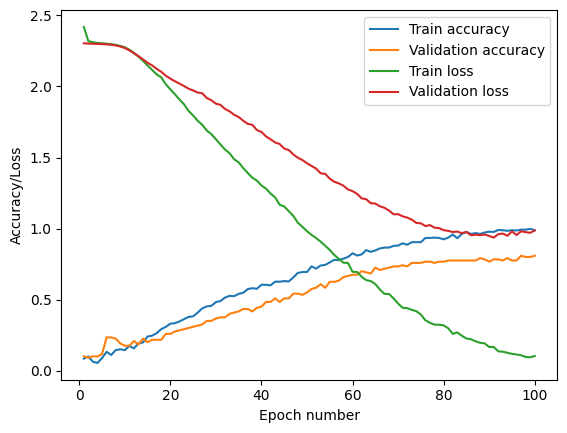

In [15]:
x=range(1,101)
plt.plot(x,out_dict['train_acc'])
plt.plot(x,out_dict['val_acc'])
plt.plot(x,out_dict['train_loss'])
plt.plot(x,out_dict['val_loss'])
plt.legend(('Train accuracy','Validation accuracy','Train loss','Validation loss'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy/Loss')

## Test

In [16]:
def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize, labels = range(10)
    )

def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

df = pd.read_csv(f'{root_dir}/metadata/test.csv')
classes = []
for i in range(10):
    classes.append(df.loc[df['label'] == i]['action'].iloc[0])

In [17]:
# Evaluate test set
test_correct = 0
test_set=framevideostack_dataset_test
confusion_matrix = np.zeros((10, 10))
with torch.no_grad():
    model.eval()
    for inputs, targets in framevideostack_loader_test:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        predictions = output.argmax(1)
        test_correct+=(predictions == targets).sum().cpu().item()

        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = test_correct / len(test_set) *100

    model.train()

print(f'Test accuracy: {test_accuracy:.3f}')

Test accuracy: 84.167


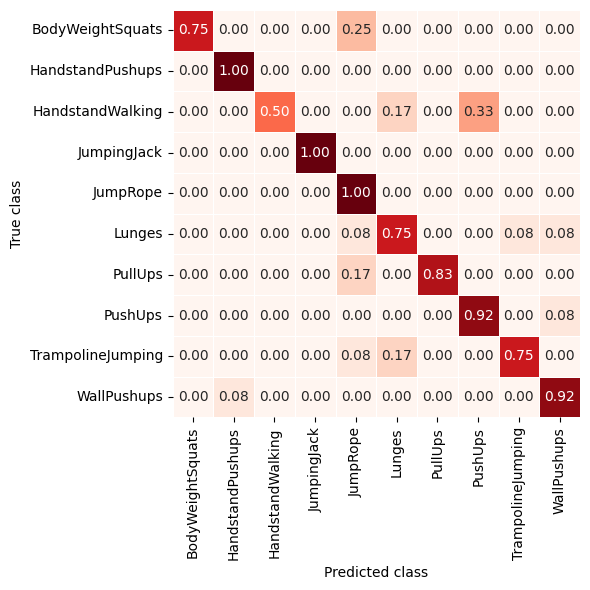

In [18]:
x_labels = [classes[i] for i in range(len(classes))]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()